In [191]:
import numpy as np
import pandas as pd
import gurobipy as gb
import random
import matplotlib.pyplot as plt

In [100]:
df = pd.read_csv("30_Industry_Portfolios.csv")
df.dropna(inplace = True)
col = df.columns.tolist()
col[0] = 'date'
df.columns = col


In [152]:
hisret = df[(df['date']>=197701)& (df['date']<=201612)]
hisret = hisret.drop('date',axis = 1)
industry = hisret.columns
sigma = hisret.cov().values
n = len(industry)

###### part b
\begin{align}
    &Min_ {P_1,P_h,x_1,x_h,x_m}
    \begin{aligned}[t]
       &-n_1\bigl(P_1-cx_1^2+\alpha cf(x_m)\big) \\
       &\qquad-n_h \bigl(P_h-cx_h^2+\alpha cf(x_m)\big)
    \end{aligned} \notag \\
    &\text{subject to} \notag \\
    & v_1 (x_1+\beta_px_m)-P_1\geq v_1(x_h-\beta_dx_m)-P_h, \\
    & v_h (x_h+\beta_px_m)-P_h\geq v_h(x_1+\beta_dx_m)-P_1, \\
    & v_1 (x_1+\beta_px_m)\geq P_1, \\
    & v_h (x_h-\beta_dx_m)\geq P_h, \\
    & x_h\geq0,\quad x_1\geq0,\quad x_h\geq x_m,\quad x_1\geq x_m,
       \quad x_m\geq0.\notag
\end{align}

In [153]:
#optimization
m = gb.Model('portfolio')
x = m.addVars(range(n),lb = 0,ub = 0.25,name = 'x')
y = m.addVars(range(n),lb = 0,ub = 1,obj = 0,vtype = gb.GRB.BINARY,name = 'y')

In [154]:
#objective
m.setObjective(sum(sum(x[i]*sigma[i][j]*x[j] for j in range(n)) for i in range(n)),sense=gb.GRB.MINIMIZE)


In [155]:
#constraint 
m.addConstr(sum(x[i] for i in range(n))==1,name = 'weight')
m.addConstrs((y[i]>=x[i] for i in range(n)),name='forcex')
m.addConstr(sum(y[i] for i in range(n))<=10,name = 'cardinality')
m.optimize()

Optimize a model with 32 rows, 60 columns and 120 nonzeros
Model has 465 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+01, 2e+02]
  Bounds range     [3e-01, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 26.1309150
Presolve time: 0.00s
Presolved: 32 rows, 60 columns, 120 nonzeros
Presolved model has 465 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)

Root relaxation: objective 1.175957e+01, 27 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.75957    0    7   26.13091   11.75957  55.0%     -    0s
H    0     0                      11.7595735   11.75957  0.00%     -    0s

Explored 1 nodes (27 simplex iterations) in 0.02 seconds
Thread

In [199]:
#minimize variance 
print('the minimal variance of the optimization is ',m.objVal)

the minimal variance of the optimization is  11.759573540722249


In [157]:
#asset weight 
for i in range(n):
    print('%s %g' % ('Weight of asset '+industry[i]+' = ',m.getVarByName("x["+str(i)+"]").X))

Weight of asset Food  =  0.230867
Weight of asset Beer  =  0.0176741
Weight of asset Smoke =  0
Weight of asset Games =  0
Weight of asset Books =  0
Weight of asset Hshld =  0.195058
Weight of asset Clths =  0
Weight of asset Hlth  =  0.0421605
Weight of asset Chems =  0
Weight of asset Txtls =  0
Weight of asset Cnstr =  0
Weight of asset Steel =  0
Weight of asset FabPr =  0
Weight of asset ElcEq =  0
Weight of asset Autos =  0
Weight of asset Carry =  0
Weight of asset Mines =  0.019369
Weight of asset Coal  =  0
Weight of asset Oil   =  0.0889693
Weight of asset Util  =  0.25
Weight of asset Telcm =  0.155902
Weight of asset Servs =  0
Weight of asset BusEq =  0
Weight of asset Paper =  0
Weight of asset Trans =  0
Weight of asset Whlsl =  0
Weight of asset Rtail =  0
Weight of asset Meals =  0
Weight of asset Fin   =  0
Weight of asset Other =  0


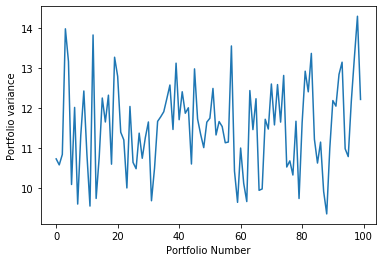

The average variance of simulated samples of 40 years return is  11.522107441206344


In [202]:
#d drawing 100 month return with replacement 
port_var = np.zeros(100)
port_weight = m.X[0:n]
for i in range(100):
    #draw months with replacement
    sample = hisret.sample(n=480, replace = True)
    new_cov = sample.cov()
    port_var[i] = new_cov.dot(port_weight).dot(port_weight)
plt.plot(port_var)
plt.xlabel('Portfolio Number')
plt.ylabel('Portfolio variance')
plt.show()
print("The average variance of simulated samples of 40 years return is ",port_var.mean())

In [197]:
#e in sample testing
portfolio_weight = m.X[0:n]
min_cov = sigma.dot(portfolio_weight).dot(portfolio_weight)
min_cov.mean()

11.75957354072225

We can see that the average portfolio variance from 100 simulated sample performance is 11.79, where the optimization minimum variance porfolio gives us a variance of 11.76 which are extremely close to each other. I would conclude that the minimum variance portfolio in 1c provide an unviased estimate of future performance if the correlation strucutre between the stocks doesnt change, then the hisotrical performance can indicate future performance and hedge out the risk to obtain a minimal variance portfolio. However, during market downtime, the correlation of stocks tend to increase significantly, and the prices can fall together, in this case the  past minimal variance portfolio is not a good unbiased estimation of the future as the variance of the entire portfolio will increase significantly due to the high correlations.